# Подготовка данных

In [1]:
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.datasets import fetch_california_housing
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")


# Increase viewable area of Pandas tables, numpy arrays, plots
np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)
sns.set()
plt.rcParams['figure.figsize'] = [16, 6]

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
# data.head()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [4]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [5]:
cols_2_drop = ['id', 'host_id','name', 'host_name', 'last_review']
data = data.drop(cols_2_drop, axis=1)

data.loc[:, 'reviews_per_month'] = data.reviews_per_month.fillna(0)

data.head()

neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0            Brooklyn    Kensington  40.64749  -73.97237     Private room   
1           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   
2           Manhattan        Harlem  40.80902  -73.94190     Private room   
3            Brooklyn  Clinton Hill  40.68514  -73.95976  Entire home/apt   
4           Manhattan   East Harlem  40.79851  -73.94399  Entire home/apt   

   price  minimum_nights  number_of_reviews  reviews_per_month  \
0    149               1                  9               0.21   
1    225               1                 45               0.38   
2    150               3                  0               0.00   
3     89               1                270               4.64   
4     80              10                  9               0.10   

   calculated_host_listings_count  availability_365  
0                               6               365  
1                               2               355  
2                               1               365  
3                               1               194  
4                               1                 0

In [6]:
# data.describe()

Удалим выбросы, которые выходят за ~ (mean + 3std)

In [7]:
data = data[data.price < data.price.mean() + 3 * data.price.std()]
data = data[data.price > 30]
data = data[data.minimum_nights < 15]
data = data[data.number_of_reviews < 150]
data = data[data.calculated_host_listings_count < 10]

data.describe()

latitude     longitude         price  minimum_nights  \
count  39854.000000  39854.000000  39854.000000    39854.000000   
mean      40.728230    -73.950653    138.106162        2.929417   
std        0.055598      0.046766    105.349192        2.322603   
min       40.499790    -74.244420     31.000000        1.000000   
25%       40.688900    -73.981880     70.000000        1.000000   
50%       40.721395    -73.954370    102.000000        2.000000   
75%       40.763640    -73.934742    175.000000        4.000000   
max       40.913060    -73.712990    860.000000       14.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       39854.000000       39854.000000                    39854.000000   
mean           19.462036           1.102264                        1.584007   
std            29.974649           1.534399                        1.277401   
min             0.000000           0.000000                        1.000000   
25%             1.000000           0.050000                        1.000000   
50%             6.000000           0.420000                        1.000000   
75%            24.000000           1.630000                        2.000000   
max           149.000000          27.950000                        9.000000   

       availability_365  
count      39854.000000  
mean          92.925654  
std          122.608711  
min            0.000000  
25%            0.000000  
50%           20.000000  
75%          172.000000  
max          365.000000

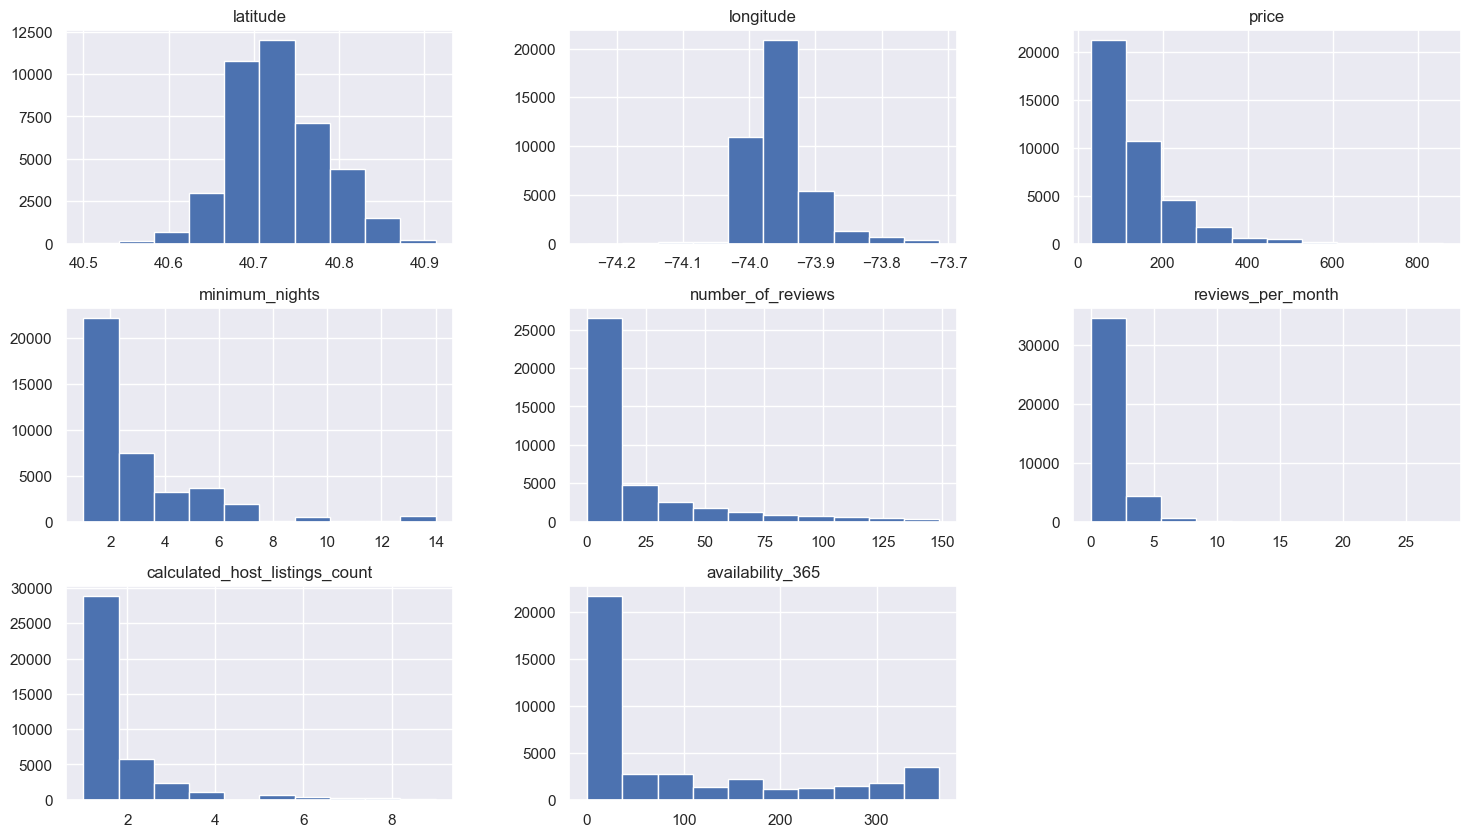

In [8]:
data.hist(figsize=(18, 10));

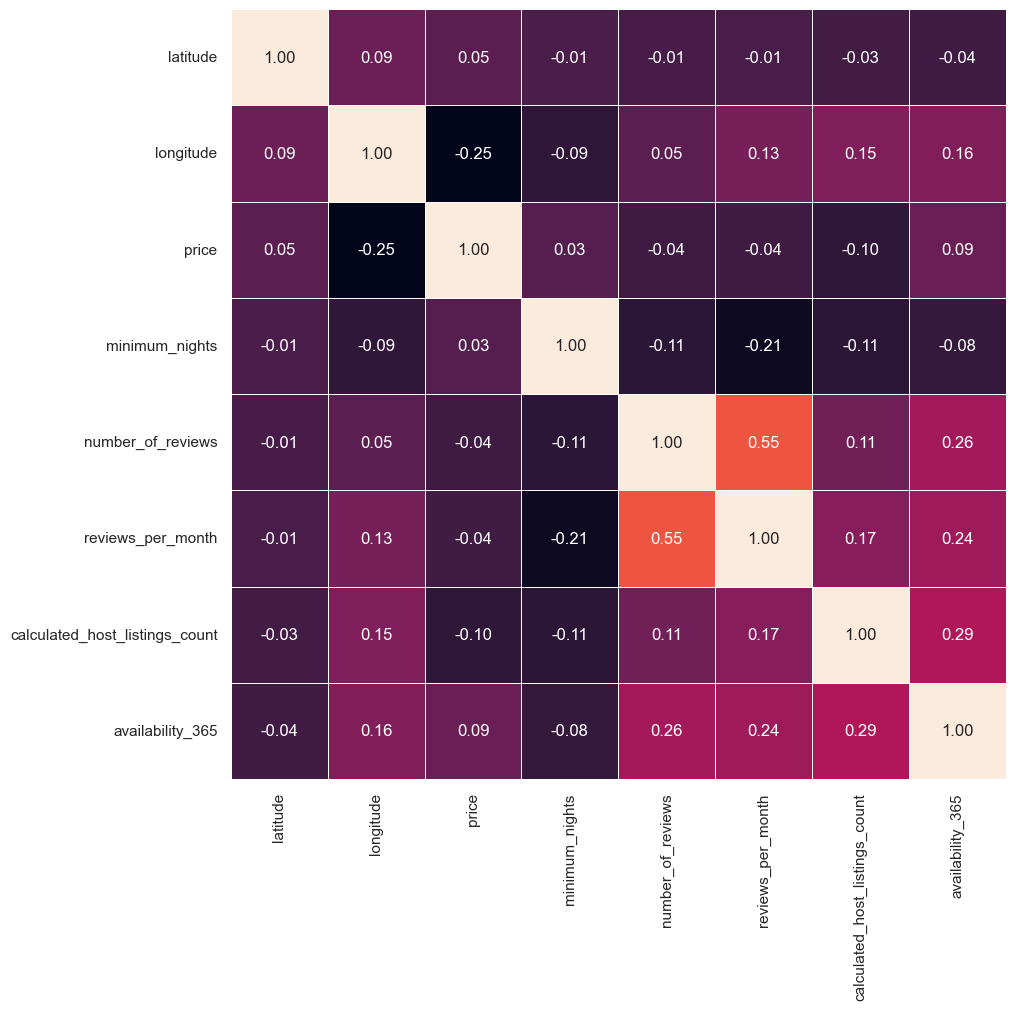

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

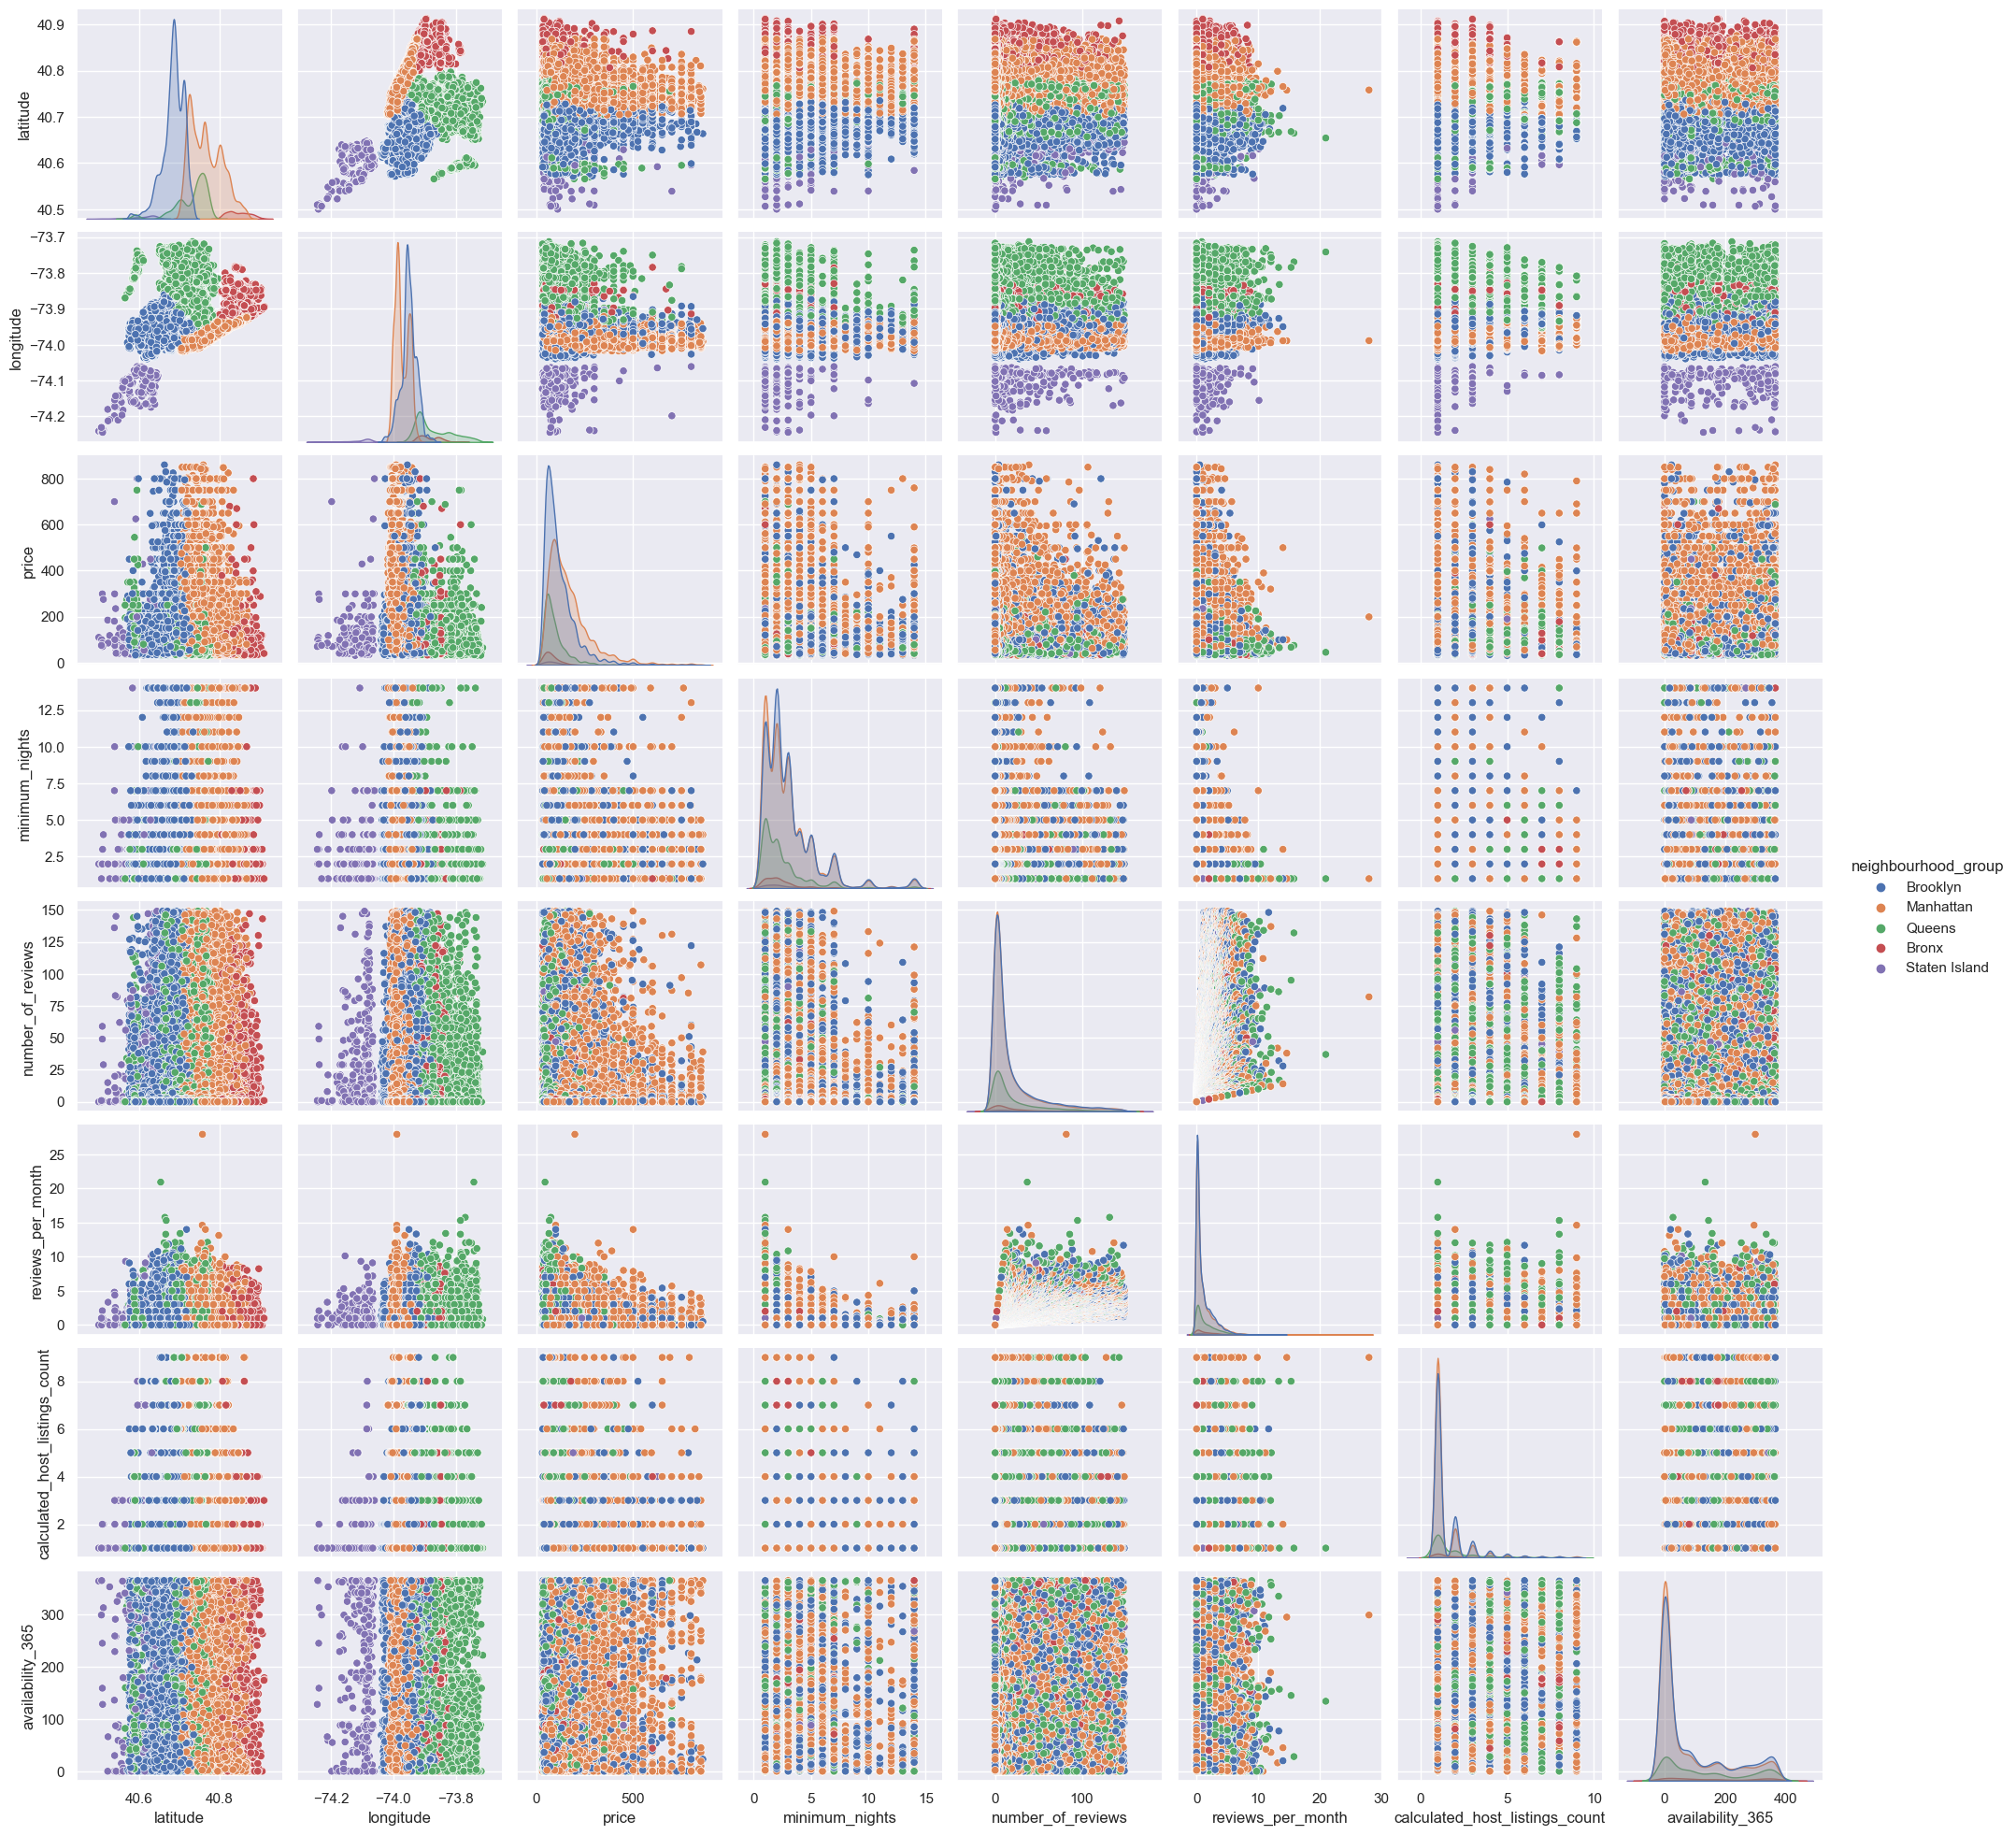

In [10]:
sns.pairplot(data, hue='neighbourhood_group');

In [11]:
nh_group = data.groupby(['neighbourhood_group'])
nh_group['price'].describe()

count        mean         std   min   25%    50%  \
neighbourhood_group                                                       
Bronx                  929.0   88.879440   74.466309  32.0  50.0   70.0   
Brooklyn             17089.0  119.817426   89.801682  31.0  62.0   95.0   
Manhattan            16723.0  171.431322  119.453018  31.0  90.0  140.0   
Queens                4788.0   99.042398   70.852988  31.0  55.0   77.0   
Staten Island          325.0  101.209231   86.623454  31.0  54.0   77.0   

                       75%    max  
neighbourhood_group                
Bronx                100.0  800.0  
Brooklyn             150.0  860.0  
Manhattan            200.0  860.0  
Queens               120.0  750.0  
Staten Island        115.0  800.0

<Figure size 1000x500 with 0 Axes>

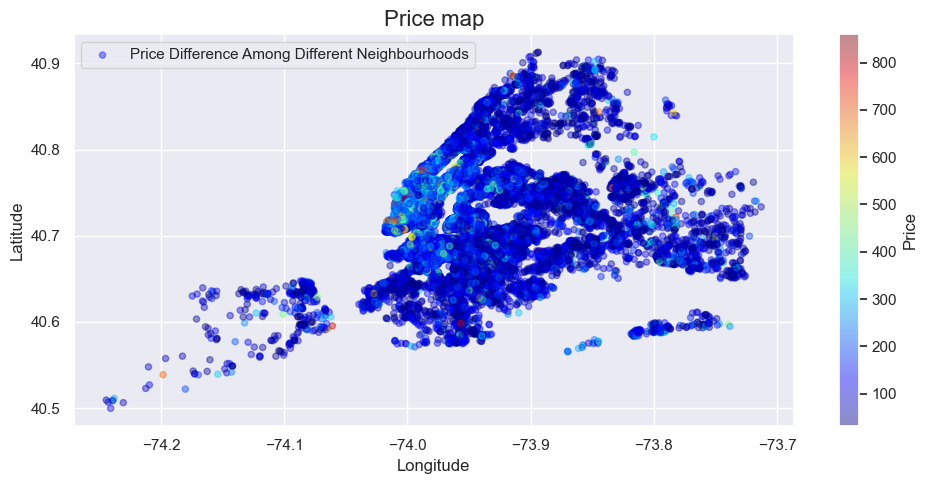

In [12]:
plt.figure(figsize=(10, 5))

viz_4 = data.plot(kind='scatter', x='longitude', y='latitude', label='Price Difference Among Different Neighbourhoods', c='price',
                cmap='jet', colorbar=True, alpha=0.4, figsize=(10, 5))

plt.title('Price map', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

colorbar = viz_4.collections[0].colorbar
colorbar.set_label('Price', fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

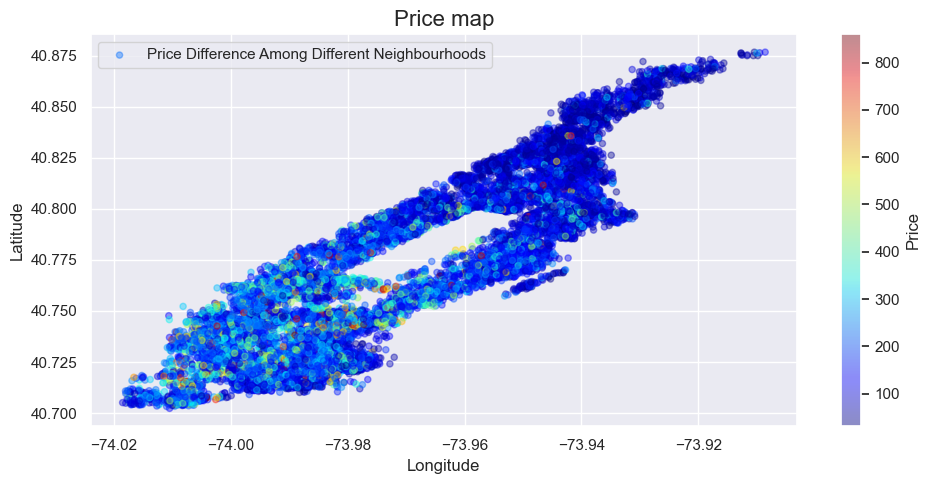

In [13]:
plt.figure(figsize=(10, 5))

data2 = data[data['neighbourhood_group'] == 'Manhattan']

viz_4 = data2.plot(kind='scatter', x='longitude', y='latitude', label='Price Difference Among Different Neighbourhoods', c='price',
                cmap='jet', colorbar=True, alpha=0.4, figsize=(10, 5))

plt.title('Price map', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

colorbar = viz_4.collections[0].colorbar
colorbar.set_label('Price', fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()

# Модель 1: LinearRegression

Преобразуем категориальные признаки:

In [14]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
data[['neighbourhood_group','neighbourhood', 'room_type']] = \
    enc.fit_transform(data[['neighbourhood_group','neighbourhood', 'room_type']])
enc.categories_

[array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'], dtype=object),
 array(['Allerton', 'Arden Heights', 'Arrochar', 'Arverne', 'Astoria', 'Bath Beach', 'Battery Park City', 'Bay Ridge', 'Bay Terrace', 'Bay Terrace, Staten Island', 'Baychester', 'Bayside', 'Bayswater', 'Bedford-Stuyvesant', 'Belle Harbor', 'Bellerose', 'Belmont', 'Bensonhurst', 'Bergen Beach', 'Boerum Hill', 'Borough Park', 'Breezy Point', 'Briarwood', 'Brighton Beach', 'Bronxdale', 'Brooklyn Heights', 'Brownsville', "Bull's Head", 'Bushwick', 'Cambria Heights', 'Canarsie', 'Carroll Gardens', 'Castle Hill', 'Castleton Corners', 'Chelsea', 'Chinatown', 'City Island', 'Civic Center', 'Claremont Village', 'Clason Point', 'Clifton', 'Clinton Hill', 'Co-op City', 'Cobble Hill', 'College Point', 'Columbia St', 'Concord', 'Concourse', 'Concourse Village', 'Coney Island', 'Corona', 'Crown Heights', 'Cypress Hills', 'DUMBO', 'Ditmars Steinway', 'Dongan Hills', 'Douglaston', 'Downtown Brooklyn', 'Dyker Heights',

In [15]:
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


X_train, X_test, y_train, y_test = train_test_split(data.drop('price', axis=1), data.price, \
                                                    test_size=0.30, random_state=42)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))
print("\n")
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
print("\n")
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))
print("Test R2 = %.4f" % r2_score(y_test, y_pred))

Train MSE = 7388.0241
Test MSE = 8014.7378


Train MAE = 54.2379
Test MAE = 55.2610


Train R2 = 0.3219
Test R2 = 0.3073


# Модель 2: с dist до центра Манхетенна

Рассчитаем центр Манхеттена и расстояние объектов до него

In [17]:
data_2 = data.copy()

In [18]:
data_manhattan = data_2[data_2.neighbourhood_group == 2]

manhattan_lat = (data_manhattan.latitude.max() + data_manhattan.latitude.min())/2
manhattan_lon = (data_manhattan.longitude.max() + data_manhattan.longitude.min())/2
manhattan_centre = [manhattan_lat, manhattan_lon]


print("Manhattan centre:", manhattan_centre) #Somewhere in Central park

Manhattan centre: [40.789495, -73.96353]


Метод расчета растояния между координатами с учетом кривизны земли

In [19]:
import math

def get_dist_by_coordinates(point1, point2):
    EARTH_RADIUS = 6372795
        
    lat1 = point1[0] * math.pi / 180;
    lat2 = point2[0] * math.pi / 180;
    long1 = point1[1] * math.pi / 180;
    long2 = point2[1] * math.pi / 180;
        
    a = math.acos(math.sin(lat1) * math.sin(lat2) + math.cos(lat1) * math.cos(lat2) * math.cos(long2 - long1));
    return EARTH_RADIUS * a / 1000; # Distance in km

Добавим признак с растоянием каждого объекта до центра Манхетенна

In [20]:
data_2["dist"] = data_2.apply(lambda x: get_dist_by_coordinates(manhattan_centre, [x["latitude"], x["longitude"]]), axis=1)
data_2.head()

neighbourhood_group  neighbourhood  latitude  longitude  room_type  price  \
0                  1.0          108.0  40.64749  -73.97237        1.0    149   
1                  2.0          127.0  40.75362  -73.98377        0.0    225   
2                  2.0           94.0  40.80902  -73.94190        1.0    150   
4                  2.0           61.0  40.79851  -73.94399        0.0     80   
5                  2.0          137.0  40.74767  -73.97500        0.0    200   

   minimum_nights  number_of_reviews  reviews_per_month  \
0               1                  9               0.21   
1               1                 45               0.38   
2               3                  0               0.00   
4              10                  9               0.10   
5               3                 74               0.59   

   calculated_host_listings_count  availability_365       dist  
0                               6               365  15.812255  
1                               2               355   4.339203  
2                               1               365   2.834269  
4                               1                 0   1.926828  
5                               1               129   4.751317

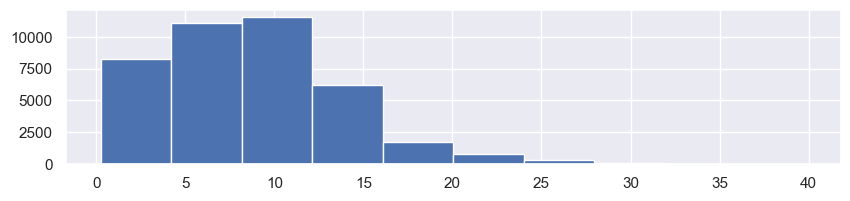

In [21]:
data_2["dist"].hist(figsize=(10, 2));

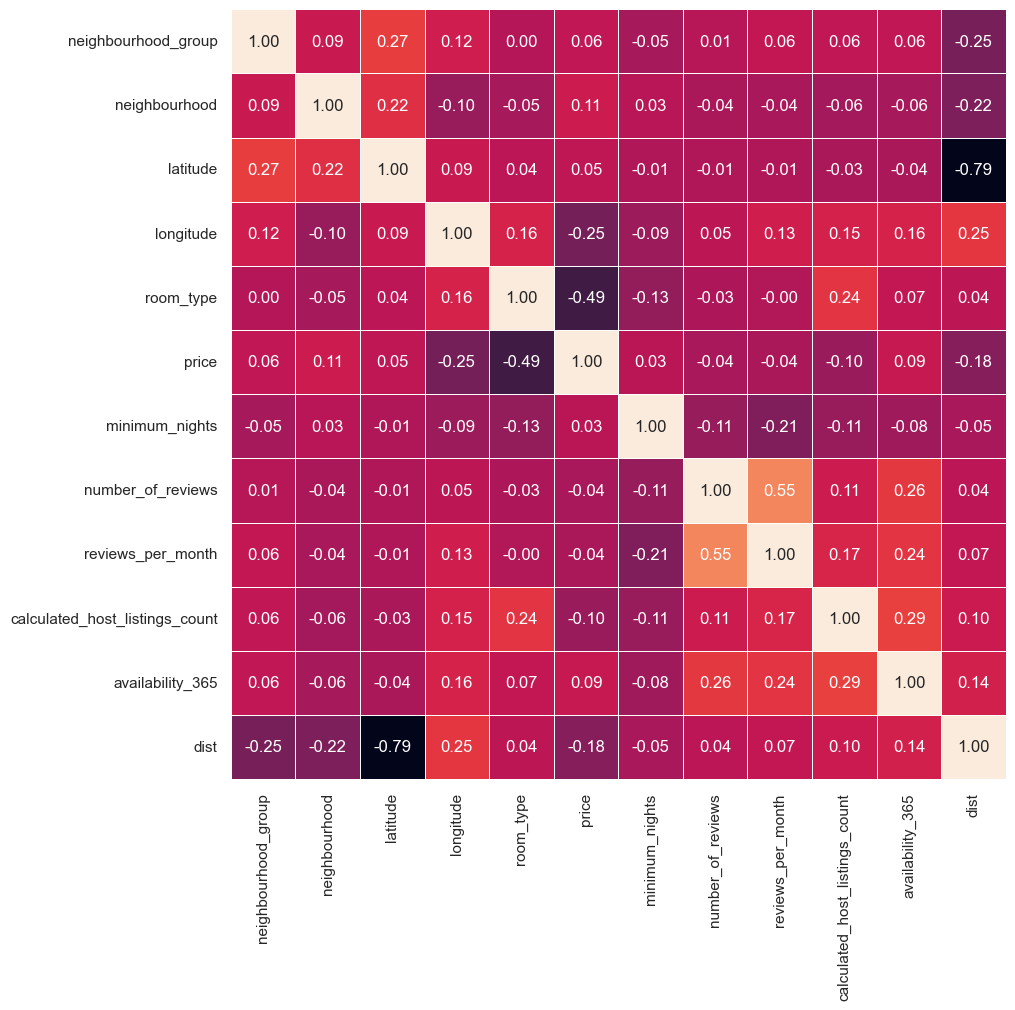

In [22]:
plt.figure(figsize=(10, 10))
sns.heatmap(data_2.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

In [23]:
# sns.pairplot(data_2, hue='neighbourhood_group');

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data_2.drop('price', axis=1), data_2.price, \
                                                    test_size=0.30, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))
print("\n")
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
print("\n")
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))
print("Test R2 = %.4f" % r2_score(y_test, y_pred))

Train MSE = 7249.3314
Test MSE = 7902.9358


Train MAE = 54.0503
Test MAE = 55.0500


Train R2 = 0.3346
Test R2 = 0.3170


# Модель 3: BaggingRegressor

In [25]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(data_2.drop('price', axis=1), data.price, \
                                                    test_size=0.30, random_state=42)

model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=10, random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))
print("\n")
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
print("\n")
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))
print("Test R2 = %.4f" % r2_score(y_test, y_pred))


Train MSE = 1214.5139
Test MSE = 7301.7375


Train MAE = 19.9838
Test MAE = 51.0746


Train R2 = 0.8885
Test R2 = 0.3689


# Выводы

1 Данные:

    1.1 На стоимость аренды влияет боро (neighbourhood_group): Манхеттен и Бруклин наиболее дорогие, Бронкс, Квинс и Статен Айланд - дешевле
    1.2 Наиболее догогие объекты находятся на юге Манхеттена (что не совсем соответствует центры, который мы вычислим далее)

2 Обучение модели:

    2.1 Для сравнения были использованы LinearRegression, LinearRegression с допотнительным признаком (расстояние до центра Манхеттена) и BaggingRegressor
    2.2 У всех моделей довольно низкое качество предсказаний (по R2)
    2.3 Добавление параметра  dist незначительно повышает качестов модели
    2.4 Наилучший результат получился при испольщовании BaggingRegressor(DecisionTreeRegressor)